В данном ноутбуке я создам базовый класс, на основе которого обучу сверточную графовую нейронную сеть.

In [ ]:
!pip install torch_geometric --quiet
!pip install nni --quiet

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

Импортируем необходимые библиотеки

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split

from torch_geometric.utils import dense_to_sparse

from itertools import combinations

from multiprocessing import Pool, cpu_count

# Custom imports
import sys
sys.path.insert(1, "/kaggle/input/second-dataset/dependecies")

from Graph import Graph
from GCN import (
    GCN,
    SimpleGCN,
    SimpleGAT,
    CustomDataset,
    train_model_accuracy,
    train_model_diversity,
    get_positive_and_negative
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Основные операция DARTS search space. Добавил 'none' для начальных вершин.

In [2]:

DARTS_OPS = [
        'none',
        'max_pool_3x3',
        'avg_pool_3x3',
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',
        'dil_conv_3x3',
        'dil_conv_5x5',
    ]

encoder = OneHotEncoder(handle_unknown='ignore')


Для графовой нейронной сети нам необходимо привести операции к числовому виду. Воспользуемся one-hot-encoder.

In [3]:
encoder = OneHotEncoder(handle_unknown='ignore')
ops_array = np.array(DARTS_OPS).reshape(-1, 1)

DARTS_OPS_ONE_HOT = encoder.fit_transform(ops_array).toarray()

print(DARTS_OPS_ONE_HOT)

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


Загрузим архитектуры обученных моделей, их предсказания и точность.

In [4]:
def load_json_from_directory(directory_path):
    """
    Обходит директорию и создает список словарей из JSON файлов.

    Аргументы:
        directory_path (str): Путь к директории, содержащей JSON файлы.

    Возвращает:
        list: Список словарей, загруженных из JSON файлов.
    """
    json_data = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        json_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {file_path}: {e}")
    return json_data

In [5]:
models_dict = load_json_from_directory('third_dataset')

Посмотрю как распределена точность моделей

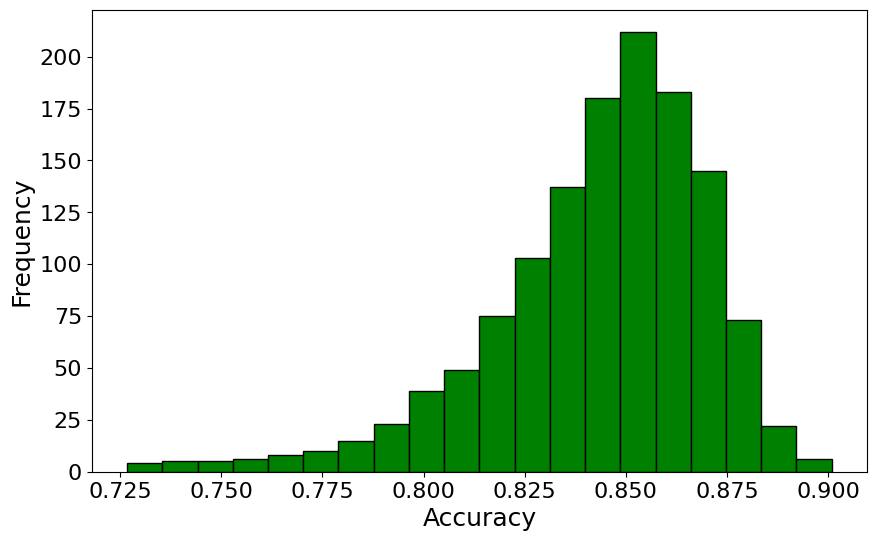

In [6]:
accuracies = [model['test_accuracy'] for model in models_dict]

plt.figure(figsize=(10, 6))

plt.hist(accuracies, bins=20, edgecolor='black', color="green")
# plt.title('Distribution of Model Accuracies')
plt.xlabel('Accuracy', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [7]:
graph = Graph(models_dict[1])

Посмотрю как выглядит граф.

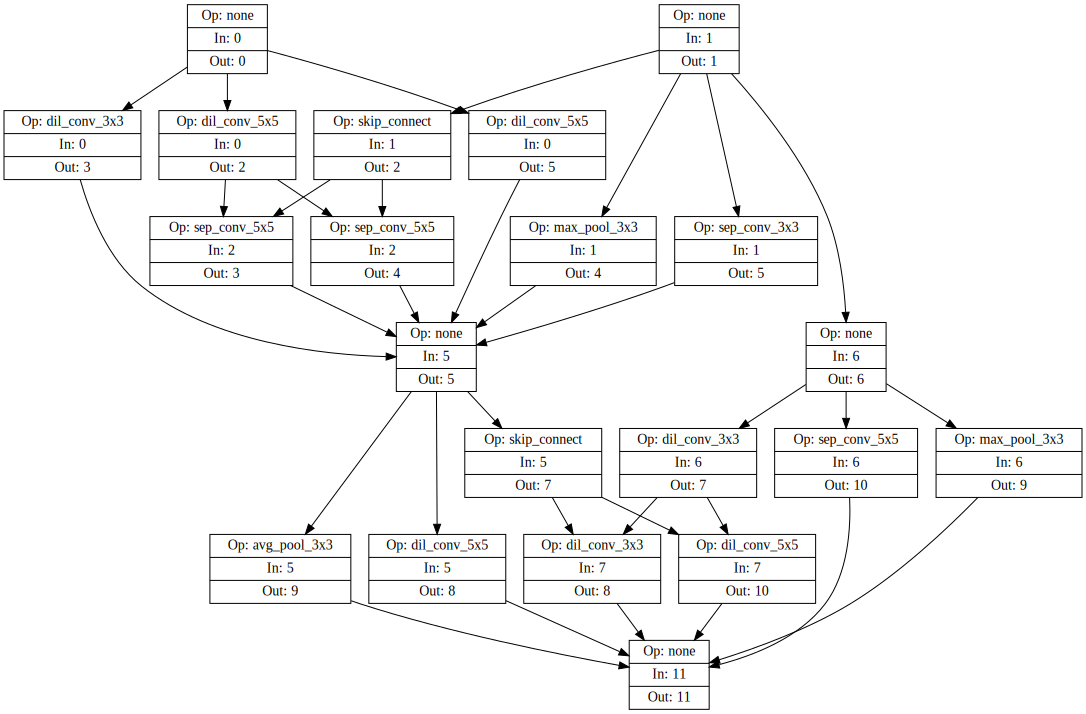

In [8]:
graph.show_graph()

In [9]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


In [10]:
graph._normal_graph

[Op: none | In: 0 | Out: 0,
 Op: dil_conv_5x5 | In: 0 | Out: 2,
 Op: dil_conv_3x3 | In: 0 | Out: 3,
 Op: dil_conv_5x5 | In: 0 | Out: 5,
 Op: none | In: 1 | Out: 1,
 Op: skip_connect | In: 1 | Out: 2,
 Op: max_pool_3x3 | In: 1 | Out: 4,
 Op: sep_conv_3x3 | In: 1 | Out: 5,
 Op: sep_conv_5x5 | In: 2 | Out: 3,
 Op: sep_conv_5x5 | In: 2 | Out: 4]

In [11]:
graph._reduction_graph


[Op: none | In: 0 | Out: 0,
 Op: skip_connect | In: 0 | Out: 2,
 Op: dil_conv_5x5 | In: 0 | Out: 3,
 Op: avg_pool_3x3 | In: 0 | Out: 4,
 Op: none | In: 1 | Out: 1,
 Op: dil_conv_3x3 | In: 1 | Out: 2,
 Op: max_pool_3x3 | In: 1 | Out: 4,
 Op: sep_conv_5x5 | In: 1 | Out: 5,
 Op: dil_conv_3x3 | In: 2 | Out: 3,
 Op: dil_conv_5x5 | In: 2 | Out: 5]

Матрица смежности и описания узлов(сначала в виде строк, потом в виде one-hot векторов) представлены так

In [12]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


Рассчитаю разнообразие наивно -- просто буду говорить каков процент совпадений ответов у моделей 

In [13]:
def get_diversity(args):
    i, j, model_i, model_j = args
    preds_i = np.array(model_i["test_predictions"])
    preds_j = np.array(model_j["test_predictions"])
    distance = np.mean(preds_i == preds_j)
    return (i, j, distance)

def get_diversity_using_jensen_shannon(args):
    i, j, model_i, model_j, num_samples = args
    indices = np.random.choice(len(model_i["test_predictions"]), num_samples, replace=False)
    preds_i = np.array(model_i["test_predictions"])[indices]
    preds_j = np.array(model_j["test_predictions"])[indices]
    distance = np.mean([jensenshannon(p1, p2) for p1, p2 in zip(preds_i, preds_j)])
    return (i, j, distance)

Построю матрицу разнообразия

In [14]:
def get_diversity_matrix_naive(models_dict, num_samples=None):
    n_models = len(models_dict)
    diversity_matrix = np.eye(n_models)

    # Предобработка: обрезаем и кешируем предсказания
    cached_preds = {}
    for i in range(n_models):
        preds = np.array(models_dict[i]["test_predictions"])
        if num_samples is not None:
            preds = preds[:num_samples]
        cached_preds[i] = preds

    for i in tqdm(range(n_models), desc="Computing diversity matrix"):
        for j in range(i + 1, n_models):
            distance = np.mean(cached_preds[i] == cached_preds[j])
            diversity_matrix[i, j] = diversity_matrix[j, i] = distance

    return diversity_matrix

def get_diversity_matrix(models_dict, num_samples=2000):
    n_models = len(models_dict)
    diversity_matrix = np.eye(n_models)
    
    # Кеширование предсказаний для каждой модели (ограничиваем до num_samples, если нужно)
    cached_preds = {
        i: np.array(models_dict[i]["test_predictions"])[:num_samples]
        for i in range(n_models)
    }
    
    # Список аргументов для всех пар (i,j)
    pairs = [
        (i, j, {"test_predictions": cached_preds[i]}, {"test_predictions": cached_preds[j]}, num_samples)
        for i, j in combinations(range(n_models), 2)
    ]
    
    with Pool(processes=cpu_count()) as pool:
        results = list(
            tqdm(
                pool.imap_unordered(get_diversity_using_jensen_shannon, pairs),
                total=len(pairs),
                desc="Расчет матрицы разнообразия",
            )
        )
    
    for i, j, dist in results:
        diversity_matrix[i, j] = dist
        diversity_matrix[j, i] = dist
    
    return diversity_matrix


In [15]:
diversity_matrix = get_diversity_matrix_naive(models_dict)

Computing diversity matrix: 100%|██████████| 1300/1300 [00:44<00:00, 29.37it/s] 


100%|██████████| 1300/1300 [00:00<00:00, 5110.93it/s]


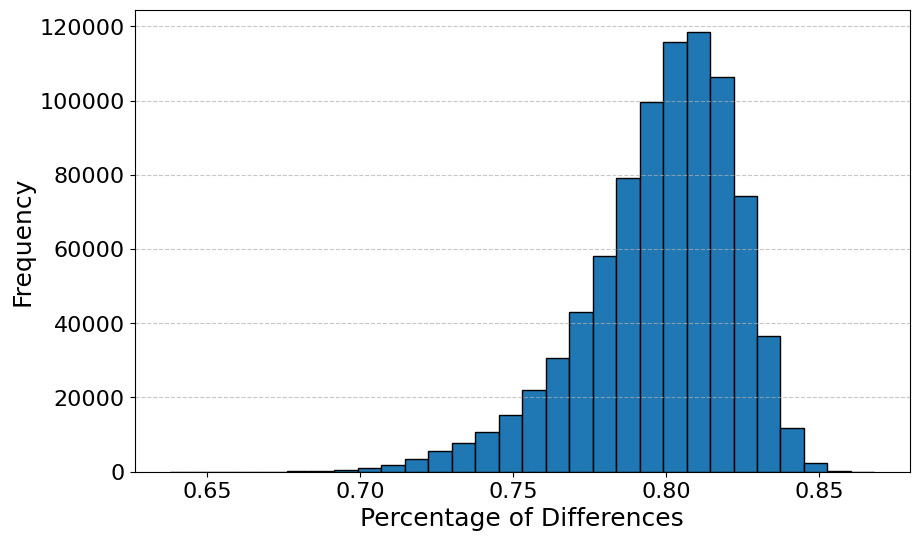

In [16]:
diversities = []

for i in tqdm(range(len(models_dict))):
    for j in range(i + 1, len(models_dict)):
        diversities.append(diversity_matrix[i, j])
diversities = np.array(diversities)

plt.figure(figsize=(10, 6))

plt.hist(diversities, bins=30, edgecolor="black")
# plt.title("Distribution of Model Diversity")
plt.xlabel("Percentage of Differences", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Для triplet loss нам нужно будет подбирать positive и negative примеры, для этого удобно будет использовать дискретную матрицу разнообразия

В ней 1 -- positive, -1 -- negative, 0 в ином случае.

In [17]:
def create_discrete_diversity_matrix(models_dict, diversity_matrix):
    discrete_diversity_matrix = np.zeros((len(models_dict), len(models_dict)))

    upper_margins = np.quantile(diversity_matrix, 0.9, axis=1)
    lower_margins = np.quantile(diversity_matrix, 0.1, axis=1)

    discrete_diversity_matrix[diversity_matrix > upper_margins[:, None]] = 1
    discrete_diversity_matrix[diversity_matrix < lower_margins[:, None]] = -1

    return discrete_diversity_matrix

In [18]:
discrete_diversity_matrix = create_discrete_diversity_matrix(models_dict, diversity_matrix)

Строим тренировочный и валидационный датасеты.

In [19]:
graphs = [Graph(model_dict, index=i) for (i, model_dict) in enumerate(models_dict)]
accuracies = [model['test_accuracy'] for model in models_dict]
graphs_dataset = CustomDataset(graphs, accuracies)

train_size = int(0.8 * len(graphs_dataset))  # 80% для тренировки
valid_size = len(graphs_dataset) - train_size  # Остальные 20% для теста

train_dataset, valid_dataset = random_split(graphs_dataset, [train_size, valid_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(valid_dataset)}")

100%|██████████| 1300/1300 [00:06<00:00, 186.94it/s]


Train dataset size: 1040
Test dataset size: 260


In [20]:
def triplet_loss(anchor, positive, negative, margin=0.1):
    d_ap = (anchor - positive).pow(2).sum(-1)
    d_an = (anchor - negative).pow(2).sum(-1)
    
    loss = F.relu(d_ap - d_an + margin)
    return loss.mean()

In [21]:
def extract_embeddings(model, dataset, device):
    model.to(device)
    model.eval()
    embeddings = []
    indices = []
    
    with torch.no_grad():
        for data in dataset:
            adj, features, index, _ = data
            
            # Перемещение данных на GPU (если используется)
            adj = adj.to(device)
            features = features.to(device)

            # Преобразование матрицы смежности в edge_index
            edge_index, _ = dense_to_sparse(adj)

            # Получение эмбеддинга графа
            embedding = model(features, edge_index)

            embeddings.append(embedding.cpu().numpy())
            indices.append(index)

    embeddings = np.vstack(embeddings)
    return embeddings, indices

Обучим модель предсказывать точность по архитектуре.

In [23]:
input_dim = graphs_dataset[0][1].shape[1]
embedding_dim = 32
hidden_dim = 128  # Размерность скрытого слоя
output_dim = 1
num_epochs = 15

model_accuracy = GCN(input_dim, output_dim, dropout=0)
optimizer = torch.optim.AdamW(model_accuracy.parameters(), lr=1e-4)
criterion = nn.MSELoss()

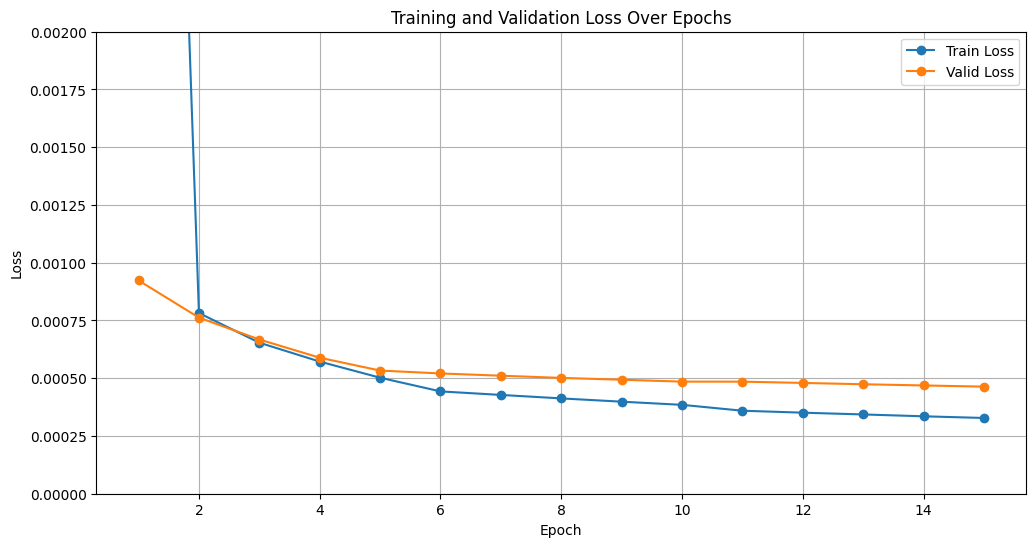

Training Progress: 100%|██████████| 15/15 [11:28<00:00, 45.87s/it]

Epoch 15, Train Loss: 0.0003, Valid Loss: 0.0005, LR: 0.000013


In [24]:
train_model_accuracy(
    model_accuracy,
    train_dataset,
    valid_dataset,
    optimizer,
    criterion,
    num_epochs,
    device=device,
    developer_mode=False
);

In [25]:
embeddings = extract_embeddings(model_accuracy, valid_dataset, device=device)[0]
for i, (adj, features, index, accuracy) in enumerate(valid_dataset):
    print(f"Index: {index:04d}, Accuracy: {accuracy.item():.3f}, Embedding: {embeddings[i][0]:.3f}")
    if i >= 20:
        break

Index: 0563, Accuracy: 0.873, Embedding: 0.847
Index: 1053, Accuracy: 0.856, Embedding: 0.870
Index: 0965, Accuracy: 0.857, Embedding: 0.877
Index: 0128, Accuracy: 0.844, Embedding: 0.842
Index: 0783, Accuracy: 0.846, Embedding: 0.864
Index: 0474, Accuracy: 0.804, Embedding: 0.831
Index: 0256, Accuracy: 0.818, Embedding: 0.849
Index: 0831, Accuracy: 0.840, Embedding: 0.853
Index: 0188, Accuracy: 0.805, Embedding: 0.847
Index: 0354, Accuracy: 0.818, Embedding: 0.815
Index: 1196, Accuracy: 0.818, Embedding: 0.826
Index: 1159, Accuracy: 0.849, Embedding: 0.848
Index: 0001, Accuracy: 0.855, Embedding: 0.840
Index: 0646, Accuracy: 0.836, Embedding: 0.837
Index: 0239, Accuracy: 0.856, Embedding: 0.880
Index: 0554, Accuracy: 0.859, Embedding: 0.850
Index: 0584, Accuracy: 0.836, Embedding: 0.842
Index: 0342, Accuracy: 0.845, Embedding: 0.840
Index: 1140, Accuracy: 0.867, Embedding: 0.876
Index: 0352, Accuracy: 0.735, Embedding: 0.792
Index: 0335, Accuracy: 0.848, Embedding: 0.834


In [ ]:
input_dim = graphs_dataset[0][1].shape[1]
hidden_dim = 256  # Размерность скрытого слоя
output_dim = 16
num_epochs = 20

model = GCN(input_dim, output_dim, dropout=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = lambda anchor, positive, negative: triplet_loss(anchor, positive, negative, margin=1)

Основной код обучения модели похожести.

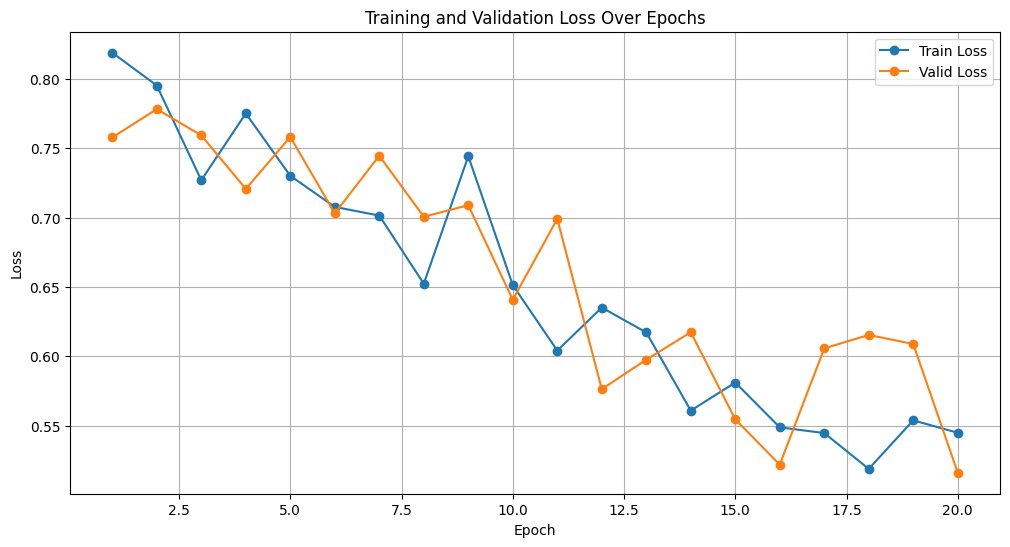

Training Progress: 100%|██████████| 20/20 [07:55<00:00, 23.75s/it]

Epoch 20, Train Loss: 0.5448, Valid Loss: 0.5160, LR: 0.000063


In [ ]:
train_model_diversity(
    model,
    train_dataset,
    valid_dataset,
    discrete_diversity_matrix,
    optimizer,
    criterion,
    num_epochs,
    device=device,
    developer_mode=False,
);

In [ ]:
def visualize_clusters(model, train_dataset, device="cpu", min_samples=3, xi=0.025, min_cluster_size=3):
  """
  Визуализирует кластеры, используя PCA для уменьшения размерности и OPTICS для кластеризации.

  Аргументы:
    model: Обученная модель для извлечения эмбеддингов.
    train_dataset: Датасет для обучения.
    device: Устройство для вычислений ("cpu" или "cuda").
    min_samples: Минимальное количество образцов для формирования кластера в OPTICS.
    xi: Параметр для определения устойчивости кластеров в OPTICS.
    min_cluster_size: Минимальный размер кластера в OPTICS.
  """
  # Извлечение эмбеддингов
  embeddings, indices = extract_embeddings(model, train_dataset, device=device)
  
  # Преобразование эмбеддингов в 2D с помощью PCA
  pca = PCA(n_components=2)
  embeddings_2d = pca.fit_transform(embeddings)

  # Кластеризация с помощью OPTICS
  optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size, metric="euclidean")
  clusters = optics.fit_predict(embeddings)

  # Визуализация кластеров
  plt.figure(figsize=(8, 6.5))
  scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1], 
    c=clusters, 
    cmap='tab10',  
    s=np.where(clusters == -1, 20, 70),  
    alpha=np.where(clusters == -1, 0.5, 1)
  )
  plt.xlabel("PCA Component 1", fontsize=16)
  plt.ylabel("PCA Component 2", fontsize=16)

  # Создание легенды для кластеров
  unique_clusters = np.unique(clusters)
  for cluster in unique_clusters:
    if cluster == -1:
      label = "Noise"
    else:
      label = f"Cluster {cluster}"
    plt.scatter([], [], color=scatter.cmap(scatter.norm(cluster)), label=label, s=50 if cluster != -1 else 20)

  plt.gca().set_facecolor('lightgrey')
  plt.show()

  return clusters

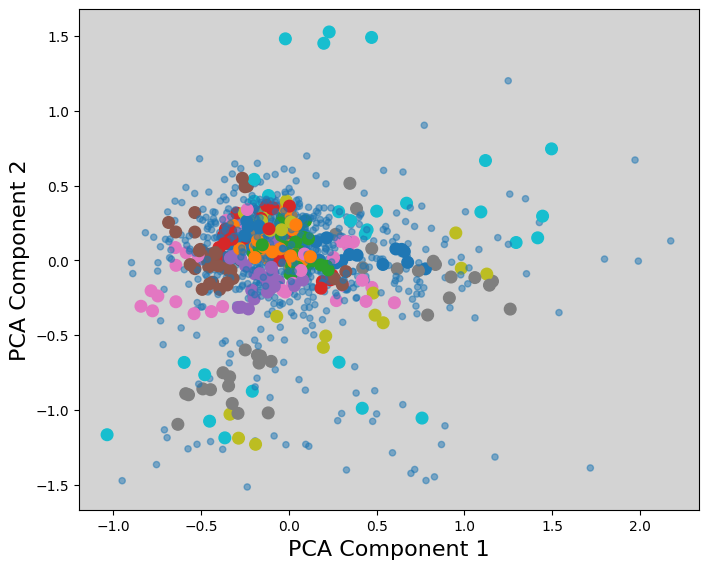

In [ ]:
clusters = visualize_clusters(
    model,
    train_dataset,
    device=device,
    min_samples=3,
    xi=0.025,
    min_cluster_size=3
)

In [ ]:
torch.save(model.state_dict(), "model_diversity_weights.pth")
torch.save(model_accuracy.state_dict(), "model_accuracy_weights.pth")

In [ ]:
embeddings[0]

array([0.8046328], dtype=float32)

In [ ]:
def compute_correlation(models_dict, dataset, model, diversity_matrix, device="cpu"):
    model.to(device)
    model.eval()

    N = len(dataset)
    embeddings = []

    with torch.no_grad():
        for adj, features, index, _ in dataset:
            adj, features = adj.to(device), features.to(device)

            edge_index, _ = dense_to_sparse(adj)

            embedding = model(features, edge_index).cpu().numpy()
            embeddings.append(embedding)

    embeddings = np.array(embeddings)

    distance_matrix = cdist(embeddings, embeddings, metric="euclidean")

    architectures = [models_dict[index] for index in dataset.indices]

    similarity_matrix = np.zeros((N, N))
    for i in tqdm(range(N), desc="Computing similarity matrix"):
        for j in range(i + 1, N):
            arch_i_index = dataset[i][2]
            arch_j_index = dataset[j][2]
            
            similarity_matrix[i, j] = diversity_matrix[arch_i_index, arch_j_index]
            similarity_matrix[j, i] = similarity_matrix[i, j]

    triu_indices = np.triu_indices(N, k=1)

    similarity_values = similarity_matrix[triu_indices]
    embedding_distances = distance_matrix[triu_indices]

    correlation, _ = pearsonr(embedding_distances, similarity_values)

    return correlation

Рассчитаю корреляции

In [ ]:
pearson_correlation = compute_correlation(models_dict, valid_dataset, model, diversity_matrix, device=device)

print(f"Корреляция Пирсона: {pearson_correlation:.3f}")

Computing similarity matrix: 100%|██████████| 260/260 [00:00<00:00, 1232.88it/s]

Корреляция Пирсона: -0.394


In [ ]:
min_samples = 10

for i in (range(len(set(clusters)) - 1)):
    cluster_indexes = np.where(clusters == i)[0]
    # print(cluster_indexes)
    
    positive_diversity = []
    negative_diversity = []
    
    for index in cluster_indexes:
        if index == cluster_indexes[0]:
            continue
        for _ in range(min_samples):
            positive, negative = get_positive_and_negative(discrete_diversity_matrix, cluster_indexes[0])
            if positive is None or negative is None:
                print(positive, negative)
                continue
            
            positive_diversity.append(get_diversity([index, positive, models_dict[index], models_dict[positive]])[-1])
            negative_diversity.append(get_diversity([index, negative, models_dict[index], models_dict[negative]])[-1])


    mean_positive_diversity = np.mean(positive_diversity) 
    mean_negative_diversity = np.mean(negative_diversity) 

    print(f"Cluster {i}:")
    print(f"  Mean Positive Diversity: {mean_positive_diversity:.4f}" if mean_positive_diversity is not None else "  No positive diversity data available.")
    print(f"  Mean Negative Diversity: {mean_negative_diversity:.4f}" if mean_negative_diversity is not None else "  No negative diversity data available.")
    if i >= 10:
        break

Cluster 0:
  Mean Positive Diversity: 0.8104
  Mean Negative Diversity: 0.7722
Cluster 1:
  Mean Positive Diversity: 0.8267
  Mean Negative Diversity: 0.7684
Cluster 2:
  Mean Positive Diversity: 0.8124
  Mean Negative Diversity: 0.7651
Cluster 3:
  Mean Positive Diversity: 0.8246
  Mean Negative Diversity: 0.7614
Cluster 4:
  Mean Positive Diversity: 0.8212
  Mean Negative Diversity: 0.7627
Cluster 5:
  Mean Positive Diversity: 0.8133
  Mean Negative Diversity: 0.7587
Cluster 6:
  Mean Positive Diversity: 0.8121
  Mean Negative Diversity: 0.7640
Cluster 7:
  Mean Positive Diversity: 0.8112
  Mean Negative Diversity: 0.7619
Cluster 8:
  Mean Positive Diversity: 0.8074
  Mean Negative Diversity: 0.7685
Cluster 9:
  Mean Positive Diversity: 0.8180
  Mean Negative Diversity: 0.7633
Cluster 10:
  Mean Positive Diversity: 0.8180
  Mean Negative Diversity: 0.7801


In [ ]:
cluster_1_indexes = np.where(clusters == 1)[0]
cluster_2_indexes = np.where(clusters == 2)[0]

similarities_within_cluster_1 = [
    get_diversity([i, j, models_dict[i], models_dict[j]])[-1]
    for i in cluster_1_indexes
    for j in cluster_1_indexes
    if i != j
]
mean_similarity_within_cluster_1 = np.mean(similarities_within_cluster_1)

similarities_between_clusters = [
    get_diversity([i, j, models_dict[i], models_dict[j]])[-1]
    for i in cluster_1_indexes
    for j in cluster_2_indexes
]
mean_similarity_between_clusters = np.mean(similarities_between_clusters)

print(f"Средняя похожесть внутри первого кластера: {mean_similarity_within_cluster_1:.4f}")
print(f"Средняя похожесть между первым и вторым кластерами: {mean_similarity_between_clusters:.4f}")

Средняя похожесть внутри первого кластера: 0.8200
Средняя похожесть между первым и вторым кластерами: 0.8054


In [ ]:
with open("logs.txt", "w", encoding="utf-8") as log:
    for index in cluster_1_indexes:
        tmp_graph = Graph(models_dict[index], index=index)
        for key, value in models_dict[index]["architecture"].items():
            log.write(f"{key}: {value}\n")
        log.write("\n")  # Добавляем пустую строку между архитектурами